In [31]:
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import PULP_CBC_CMD, LpMinimize, LpProblem, LpStatus, LpVariable, lpSum, value

In [39]:
BASE_DIR = Path().resolve()

# prices = pd.read_csv(BASE_DIR / "data" / "prices.csv")
prices = pd.read_csv(BASE_DIR / "data" / "prices_with_generation.csv")

prices["timestamp"] = pd.to_datetime(prices["timestamp"])
prices["hour"] = prices["timestamp"].dt.hour
prices = prices.set_index("timestamp").sort_index(ascending=True)

# €/Wh -> €/kWh: Solution will be in kWh
prices["energy_price"] = prices["energy_price"] / 1000

prices.head()

,energy_price,time_block,generation,hour
timestamp,,,,
2024-01-01 01:00:00,0.00010,4.0,0.0,1
2024-01-01 02:00:00,0.00001,4.0,0.0,2
2024-01-01 03:00:00,0.00003,4.0,0.0,3
2024-01-01 04:00:00,0.00000,4.0,0.0,4
2024-01-01 05:00:00,0.00000,4.0,0.0,5


In [ ]:
@dataclass
class Battery:
    capacity: float
    charge_rate: float
    soc_range_percentage: tuple[float, float]

    @property
    def soc_min(self) -> float:
        return self.capacity * self.soc_range_percentage[0] / 100

    @property
    def soc_max(self) -> float:
        return self.capacity * self.soc_range_percentage[1] / 100

    @property
    def power(self) -> float:
        return self.capacity * self.charge_rate


def optimize(prices: pd.DataFrame, battery: Battery) -> pd.DataFrame:
    """Battery arbitrage optimization using linear programming."""

    timestamps = prices.index

    # --------------------
    # Problem definition
    # --------------------
    objective = LpProblem("Peaks", LpMinimize)

    # --------------------
    # Variables
    # --------------------
    # Battery charge/discharge in interval t (+ charge, − discharge)
    charge_rate_var = {
        t: LpVariable(
            f"x_{t}",
            lowBound=-battery.power,
            upBound=battery.power,
            cat="Continuous",
        )
        for t in timestamps
    }

    # State of charge at beginning of interval t
    soc_var = {
        t: LpVariable(
            f"y_{t}",
            lowBound=battery.soc_min,
            upBound=battery.soc_max,
            cat="Continuous",
        )
        for t in timestamps
    }

    # auxiliary variable for set 5 of constraints
    is_discharging_var = {t: LpVariable(f"b_{t}", cat="Binary") for t in timestamps}

    # --------------------
    # Objective function
    # --------------------
    objective += (
        lpSum(charge_rate_var[t] * prices.loc[t, "energy_price"] for t in timestamps),
        "minimize_energy_cost",
    )

    # --------------------
    # Constraints
    # --------------------
    # Initial SOC: Battery is full in the beginning
    objective += soc_var[timestamps[0]] == battery.soc_max, "initial_SOC"

    # SOC between two subsequent steps are connected through the charge rate between them
    for t, t_prev in zip(timestamps[1:], timestamps[:-1]):
        objective += (
            soc_var[t] == soc_var[t_prev] + charge_rate_var[t_prev],
            f"soc_balance_{t}",
        )

    # Charging / discharging limits based on SOC: avoid over(dis)charging the battery
    for t in timestamps:
        objective += (
            charge_rate_var[t] >= -(soc_var[t] - battery.soc_min),
            f"discharge_limit_{t}",
        )
        objective += (
            charge_rate_var[t] <= (battery.soc_max - soc_var[t]),
            f"charge_limit_{t}",
        )

    ### 2nd SET OF CONSTRAINTS
    # The battery must not charge between 4:00 and 6:00.
    no_charge_hours = [4, 5, 6]
    for t in timestamps:
        if t.hour in no_charge_hours:
            objective += charge_rate_var[t] <= 0, f"NoCharge_{t}"

    ## 3nd SET OF CONSTRAINTS
    # SOC at 8h must be at least 50%
    for t in timestamps:
        if t.hour == 8:
            objective += soc_var[t] >= 0.5 * battery.capacity, f"SOC_at_8AM_min{t}"

    ## 4th SET OF CONSTRAINTS
    # When solar production/generation is available, assume charging the battery only with solar energy.
    # Charging must therefore not exceed production.
    for t in timestamps:
        objective += (
            charge_rate_var[t] <= prices.loc[t, "generation"],
            f"generation_limit_{t}",
        )

    ## 5th SET OF CONSTRAINTS
    # Discharging is allowed only if the current price is above the average price
    # add binary variable b_i
    for t in timestamps:
        # If is_discharging = 0 → charge_rate ≥ 0  (not discharging)
        # If is_discharging = 1 → charge_rate ≤ 0 (discharging)
        objective += (
            charge_rate_var[t] >= -battery.power * is_discharging_var[t],
            f"discharge_indicator_{t}",
        )
        # If is_discharging = 1 → charge_rate ≤ 0 (discharging)
        objective += (
            charge_rate_var[t] <= (1 - is_discharging_var[t]) * battery.power,
            f"discharge_indicator_b_{t}",
        )

    max_energy_price = prices["energy_price"].max()
    avg_energy_price = prices["energy_price"].mean()
    for t in timestamps:
        objective += (
            prices.loc[t, "energy_price"] - avg_energy_price
            <= max_energy_price * is_discharging_var[t],
            f"price_upper_{t}",
        )
        objective += (
            prices.loc[t, "energy_price"] - avg_energy_price
            >= -max_energy_price * (1 - is_discharging_var[t]),
            f"price_lower_{t}",
        )

    # --------------------
    # Solve
    # --------------------
    objective.writeLP("ilp-model.lp")
    objective.solve(PULP_CBC_CMD(msg=False, timeLimit=120))

    print("Solver Status:", LpStatus[objective.status])
    print("Objective value:", round(value(objective.objective), 2))

    # --------------------
    # Results
    # --------------------
    res = pd.DataFrame(
        {
            "timestamp": prices.index,
            "price": prices["energy_price"],
            "battery(x)": [charge_rate_var[t].varValue for t in timestamps],
            "soc": [soc_var[t].varValue for t in timestamps],
        }
    )
    res["charging"] = res["battery(x)"].clip(lower=0)
    res["discharging"] = -res["battery(x)"].clip(upper=0)
    res["cost"] = res["price"] * res["battery(x)"]

    return res

In [ ]:
def optimize(prices: pd.DataFrame, battery: Battery) -> pd.DataFrame:
    """Battery arbitrage optimization using linear programming."""

    timestamps = prices.index

    # --------------------
    # Problem definition
    # --------------------
    objective = LpProblem("Peaks", LpMinimize)

    # --------------------
    # Variables
    # --------------------
    # Battery charge/discharge in interval t (+ charge, − discharge)
    charge_rate_var = {
        t: LpVariable(
            f"x_{t}",
            lowBound=-battery.power,
            upBound=battery.power,
            cat="Continuous",
        )
        for t in timestamps
    }

    # State of charge at beginning of interval t
    soc_var = {
        t: LpVariable(
            f"y_{t}",
            lowBound=battery.soc_min,
            upBound=battery.soc_max,
            cat="Continuous",
        )
        for t in timestamps
    }

    # auxiliary variable for set 5 of constraints
    is_discharging_var = {t: LpVariable(f"b_{t}", cat="Binary") for t in timestamps}

    # --------------------
    # Objective function
    # --------------------
    objective += (
        lpSum(charge_rate_var[t] * prices.loc[t, "energy_price"] for t in timestamps),
        "minimize_energy_cost",
    )

    # --------------------
    # Constraints
    # --------------------
    # Initial SOC: Battery is full in the beginning
    objective += soc_var[timestamps[0]] == battery.soc_max, "initial_SOC"

    # SOC between two subsequent steps are connected through the charge rate between them
    for t, t_prev in zip(timestamps[1:], timestamps[:-1]):
        objective += (
            soc_var[t] == soc_var[t_prev] + charge_rate_var[t_prev],
            f"soc_balance_{t}",
        )

    # Charging / discharging limits based on SOC: avoid over(dis)charging the battery
    for t in timestamps:
        objective += (
            charge_rate_var[t] >= -(soc_var[t] - battery.soc_min),
            f"discharge_limit_{t}",
        )
        objective += (
            charge_rate_var[t] <= (battery.soc_max - soc_var[t]),
            f"charge_limit_{t}",
        )

    ### 2nd SET OF CONSTRAINTS
    # The battery must not charge between 4:00 and 6:00.
    no_charge_hours = [4, 5, 6]
    for t in timestamps:
        if t.hour in no_charge_hours:
            objective += charge_rate_var[t] <= 0, f"NoCharge_{t}"

    ## 3nd SET OF CONSTRAINTS
    # SOC at 8h must be at least 50%
    for t in timestamps:
        if t.hour == 8:
            objective += soc_var[t] >= 0.5 * battery.capacity, f"SOC_at_8AM_min{t}"

    ## 4th SET OF CONSTRAINTS
    # When solar production/generation is available, assume charging the battery only with solar energy.
    # Charging must therefore not exceed production.
    for t in timestamps:
        objective += (
            charge_rate_var[t] <= prices.loc[t, "generation"],
            f"generation_limit_{t}",
        )

    ## 5th SET OF CONSTRAINTS
    # Discharging is allowed only if the current price is above the average price
    # add binary variable b_i
    for t in timestamps:
        # If is_discharging = 0 → charge_rate ≥ 0  (not discharging)
        # If is_discharging = 1 → charge_rate ≤ 0 (discharging)
        objective += (
            charge_rate_var[t] >= -battery.power * is_discharging_var[t],
            f"discharge_indicator_{t}",
        )
        # If is_discharging = 1 → charge_rate ≤ 0 (discharging)
        objective += (
            charge_rate_var[t] <= (1 - is_discharging_var[t]) * battery.power,
            f"discharge_indicator_b_{t}",
        )

    max_energy_price = prices["energy_price"].max()
    avg_energy_price = prices["energy_price"].mean()
    for t in timestamps:
        objective += (
            prices.loc[t, "energy_price"] - avg_energy_price
            <= max_energy_price * is_discharging_var[t],
            f"price_upper_{t}",
        )
        objective += (
            prices.loc[t, "energy_price"] - avg_energy_price
            >= -max_energy_price * (1 - is_discharging_var[t]),
            f"price_lower_{t}",
        )

    # --------------------
    # Solve
    # --------------------
    objective.writeLP("ilp-model.lp")
    objective.solve(PULP_CBC_CMD(msg=False, timeLimit=120))

    print("Solver Status:", LpStatus[objective.status])
    print("Objective value:", round(value(objective.objective), 2))

    # --------------------
    # Results
    # --------------------
    res = pd.DataFrame(
        {
            "timestamp": prices.index,
            "price": prices["energy_price"],
            "battery(x)": [charge_rate_var[t].varValue for t in timestamps],
            "soc": [soc_var[t].varValue for t in timestamps],
        }
    )
    res["charging"] = res["battery(x)"].clip(lower=0)
    res["discharging"] = -res["battery(x)"].clip(upper=0)
    res["cost"] = res["price"] * res["battery(x)"]

    return res

In [52]:
battery = Battery(capacity=250, charge_rate=0.5, soc_range_percentage=(10, 90))
result = optimize(prices, battery)
result.head()

Solver Status: Optimal
Objective value: -4811.06


,timestamp,price,battery(x),soc,charging,discharging,cost
timestamp,,,,,,,
2024-01-01 01:00:00,2024-01-01 01:00:00,0.00010,0.0,225.0,0.0,-0.0,0.0
2024-01-01 02:00:00,2024-01-01 02:00:00,0.00001,0.0,225.0,0.0,-0.0,0.0
2024-01-01 03:00:00,2024-01-01 03:00:00,0.00003,0.0,225.0,0.0,-0.0,0.0
2024-01-01 04:00:00,2024-01-01 04:00:00,0.00000,0.0,225.0,0.0,-0.0,0.0
2024-01-01 05:00:00,2024-01-01 05:00:00,0.00000,0.0,225.0,0.0,-0.0,0.0


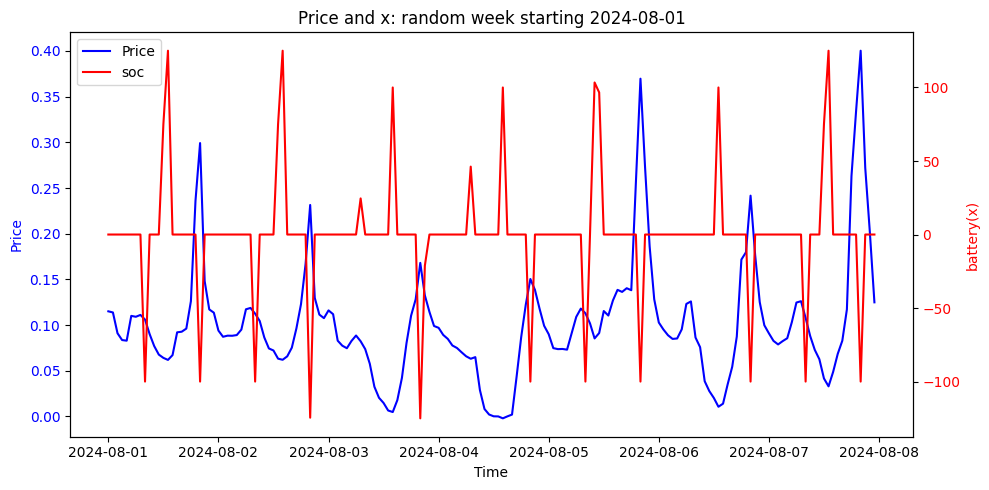

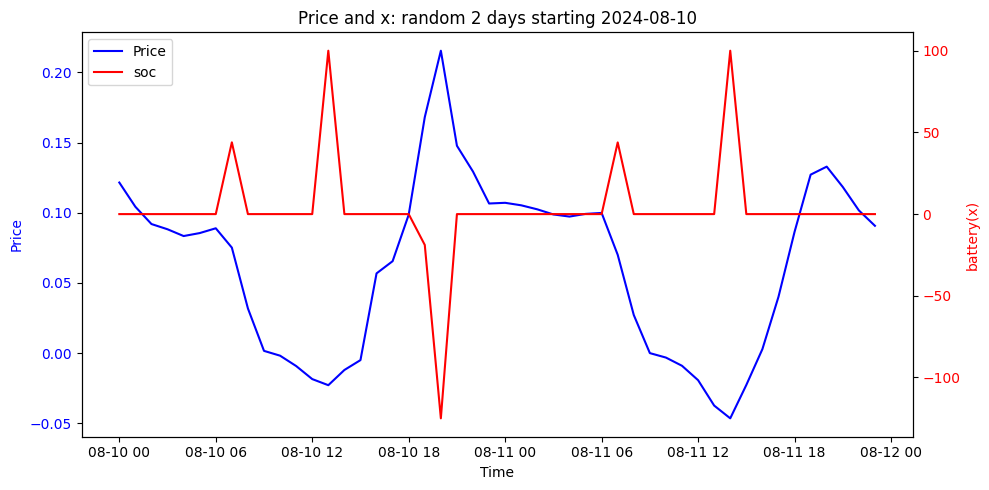

In [ ]:
# Filter for August
august = result[result["timestamp"].dt.month == 8]

# Pick a random start date (within available range)
start_date = np.random.choice(august["timestamp"].dt.date.unique())
start_date = pd.Timestamp(start_date)
end_date = start_date + pd.Timedelta(days=7)

# Slice the week
week = result[(result["timestamp"] >= start_date) & (result["timestamp"] < end_date)]
week = week.set_index("timestamp")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(week.index, week["price"], color="blue", label="Price")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
ax2.plot(week.index, week["battery(x)"], color="red", label="soc")
ax2.set_ylabel("battery(x)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title(f"Price and x: random week starting {start_date.date()}")
plt.tight_layout()
plt.show()

### RANDOM DAY - repeated code
start_date = np.random.choice(august["timestamp"].dt.date.unique())
start_date = pd.Timestamp(start_date)
end_date = start_date + pd.Timedelta(days=2)

# Slice the week
week = result[(result["timestamp"] >= start_date) & (result["timestamp"] < end_date)]
week = week.set_index("timestamp")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(week.index, week["price"], color="blue", label="Price")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
ax2.plot(week.index, week["battery(x)"], color="red", label="soc")
ax2.set_ylabel("battery(x)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# A = result['price'].mean()
# print(A)
# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title(f"Price and x: random 2 days starting {start_date.date()}")
plt.tight_layout()
plt.show()
